In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import os
import re

In [2]:

# Carga de archivos CSV
csv1 = "light_curve.csv"
df1 = pd.read_csv(csv1)
df2 = pd.read_csv("(0_0_4_30_235_5_i_0).csv")
df3 = pd.read_csv("(0_0_4_30_235_5_i_32).csv")
df4 = pd.read_csv("(0_0_4_30_235_5_i_-32).csv")


real_flux = df1['flux_normalized'].values
real_time = df1['Time'].values

simulate_flux = df2["flux_normalized"]
simulate_time = df2["Days"]

simulate_flux3 = df3["flux_normalized"]
simulate_time3 = df3["Days"]

simulate_flux4 = df4["flux_normalized"]
simulate_time4 = df4["Days"]


In [3]:
df1

,Time,flux_normalized
0,1701.781330,0.988268
1,1701.782719,0.987296
2,1701.784108,0.988784
3,1701.785497,0.987574
4,1701.786886,0.987652
...,...,...
2154,1704.817447,0.991825
2155,1704.818836,0.992287
2156,1704.820225,0.991600
2157,1704.821614,0.995831


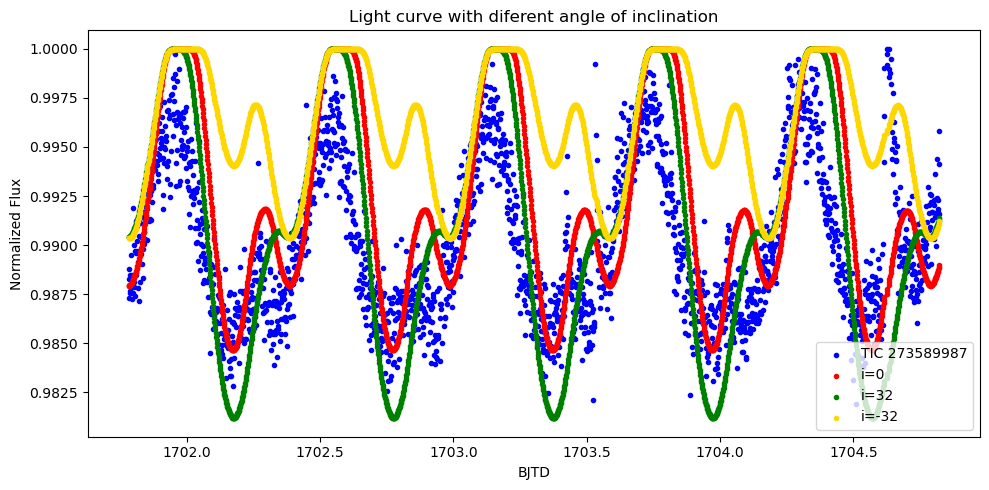

In [4]:
plt.figure(figsize=(10, 5))
plt.scatter(df1["Time"], df1["flux_normalized"], label='TIC 273589987', color='blue', marker='.', linestyle='-')
plt.scatter(df1["Time"], df2["flux_normalized"], label='i=0', color='red', marker='.', linestyle='-')
plt.scatter(df1["Time"], df3["flux_normalized"], label='i=32', color='green', marker='.', linestyle='-')
plt.scatter(df1["Time"], df4["flux_normalized"], label='i=-32', color='gold', marker='.', linestyle='-')

plt.xlabel("BJTD")
plt.ylabel("Normalized Flux")
plt.title("Light curve with diferent angle of inclination")
plt.legend()

plt.tight_layout()
plt.savefig("model1.png" , dpi=600)
plt.show()

In [5]:

df2 = pd.read_csv("test1/lat_0lon_0radii20.csv")
df2


,Days,flux_normalized
0,0.000000,0.805336
1,0.001389,0.805387
2,0.002778,0.805478
3,0.004167,0.805620
4,0.005556,0.805819
...,...,...
2155,2.993056,0.818319
2156,2.994444,0.819513
2157,2.995833,0.820775
2158,2.997222,0.822077



Top 5 light curves más parecidas:

1. Archivo: lat_60lon_90radii5.csv  |  Lat: 60.0  Lon: 90.0  Rad: 5.0  |  MSE: 0.0000260586
2. Archivo: lat_60lon_120radii5.csv  |  Lat: 60.0  Lon: 120.0  Rad: 5.0  |  MSE: 0.0000266385
3. Archivo: lat_50lon_120radii5.csv  |  Lat: 50.0  Lon: 120.0  Rad: 5.0  |  MSE: 0.0000324945
4. Archivo: lat_50lon_90radii5.csv  |  Lat: 50.0  Lon: 90.0  Rad: 5.0  |  MSE: 0.0000325419
5. Archivo: lat_60lon_60radii5.csv  |  Lat: 60.0  Lon: 60.0  Rad: 5.0  |  MSE: 0.0000325649


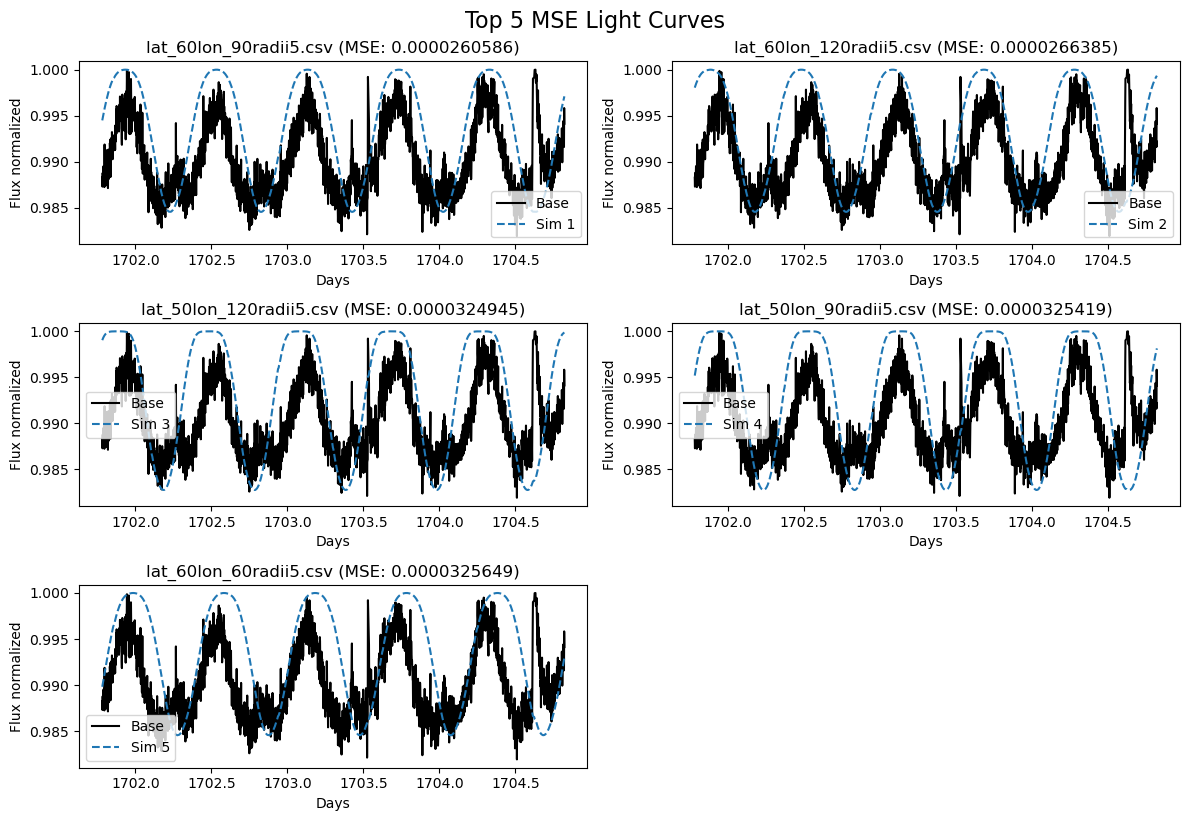

In [6]:

# --------------------------------------------------------
# Paso 1: Cargar tu curva de luz base
# --------------------------------------------------------
base_curve = pd.read_csv('light_curve.csv')
base_flux = base_curve['flux_normalized'].values
base_time = base_curve['Time'].values

# --------------------------------------------------------
# Paso 2: Carpeta de simulaciones
# --------------------------------------------------------
sim_folder = 'test1'
results = []

# --------------------------------------------------------
def extract_params(filename):
    """
    Extrae:
       lat_X
       lon_Y
       radiiZ
    Aunque vengan pegados: lat_-30lon_150radii25.csv
    """
    name = filename.replace(".csv", "")

    lat = re.search(r'lat_(-?\d+)', name)
    lon = re.search(r'lon_(-?\d+)', name)
    rad = re.search(r'radii(-?\d+)', name)

    if lat: lat = float(lat.group(1))
    if lon: lon = float(lon.group(1))
    if rad: rad = float(rad.group(1))

    return lat, lon, rad

# --------------------------------------------------------
# 3. Procesar simulaciones
# --------------------------------------------------------
for file in os.listdir(sim_folder):
    if file.endswith('.csv'):
        path = os.path.join(sim_folder, file)

        try:
            sim_curve = pd.read_csv(path)
            sim_flux = sim_curve['flux_normalized'].values
            sim_time = sim_curve['Days'].values

            # Recorte al mínimo largo (SIN interpolación)
            n = min(len(base_flux), len(sim_flux))
            base_cut = base_flux[:n]
            sim_cut = sim_flux[:n]

            # MSE
            mse_value = mean_squared_error(base_cut, sim_cut)

            # Parámetros desde el nombre (CORRECTO)
            lat, lon, rad = extract_params(file)

            results.append({
                'file': file,
                'lat': lat,
                'lon': lon,
                'rad': rad,
                'mse': mse_value,
                'flux': sim_cut,
                'time': base_time[:n]
            })

        except Exception as e:
            print(f"Error leyendo {file}: {e}")

# --------------------------------------------------------
# 4. Top 5
# --------------------------------------------------------
top5 = sorted(results, key=lambda x: x['mse'])[:5]

print("\nTop 5 light curves más parecidas:\n")
for i, r in enumerate(top5, 1):
    print(f"{i}. Archivo: {r['file']}  |  Lat: {r['lat']}  Lon: {r['lon']}  Rad: {r['rad']}  |  MSE: {r['mse']:.10f}")

# --------------------------------------------------------
# 5. Gráficas
# --------------------------------------------------------
plt.figure(figsize=(12, 8))
for i, r in enumerate(top5, 1):
    plt.subplot(3, 2, i)
    plt.plot(r['time'], base_cut[:len(r['flux'])], label='Base', color='black')
    plt.plot(r['time'], r['flux'], label=f"Sim {i}", linestyle='--')
    plt.title(f"{r['file']} (MSE: {r['mse']:.10f})")
    plt.xlabel("Days")
    plt.ylabel("Flux normalized")
    plt.legend()

plt.tight_layout()
plt.suptitle("Top 5 MSE Light Curves", fontsize=16, y=1.02)
plt.show()